In [1]:
import os
import sys
import psycopg2
import warnings

import cufflinks as cf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from scipy.signal import savgol_filter

from utils import local_data
from utils import window

%matplotlib inline
warnings.filterwarnings('ignore')

/usr/local/anaconda/envs/dscience/lib/python3.6/site-packages/plotly/graph_objs/_deprecations.py:558: DeprecationWarning:

plotly.graph_objs.YAxis is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.layout.YAxis
  - plotly.graph_objs.layout.scene.YAxis


/usr/local/anaconda/envs/dscience/lib/python3.6/site-packages/plotly/graph_objs/_deprecations.py:531: DeprecationWarning:

plotly.graph_objs.XAxis is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.layout.XAxis
  - plotly.graph_objs.layout.scene.XAxis




In [2]:
path = os.path.join(local_data, 's4_avaliate_smooth.pkl.xz')

if os.path.exists(path):
    df_s4 = pd.read_pickle(path, compression='xz')
else:
    conn = psycopg2.connect(database="data-research",
                            user="data-research",
                            password="data-research",
                            host="localhost",
                            port=5432)
    query = '''select scintillation.eventdate, scintillation.s4 
               from scintillation inner join station on 
               scintillation.station = station.identificationstation 
               where station.identificationstation = 'sj2' 
               order by scintillation.eventdate; 
            '''
    df_s4 = pd.read_sql_query(query, con=conn)
    
    # convert df_s4 to timeseries
    df_s4['eventdate'] = pd.to_datetime(df_s4['eventdate'], utc=True)
    df_s4.index = df_s4['eventdate']
    del df_s4['eventdate']
    df_s4.to_pickle(path, compression='xz')
    conn.close()

In [3]:
df_s4.info()
df_s4.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1968667 entries, 2013-01-25 18:56:00+00:00 to 2014-12-22 06:38:00+00:00
Data columns (total 1 columns):
s4    float64
dtypes: float64(1)
memory usage: 30.0 MB


,s4
eventdate,
2013-01-25 18:56:00+00:00,0.14
2013-01-25 18:56:00+00:00,0.17
2013-01-25 18:58:00+00:00,0.11
2013-01-25 18:58:00+00:00,0.12
2013-01-25 18:58:00+00:00,0.12


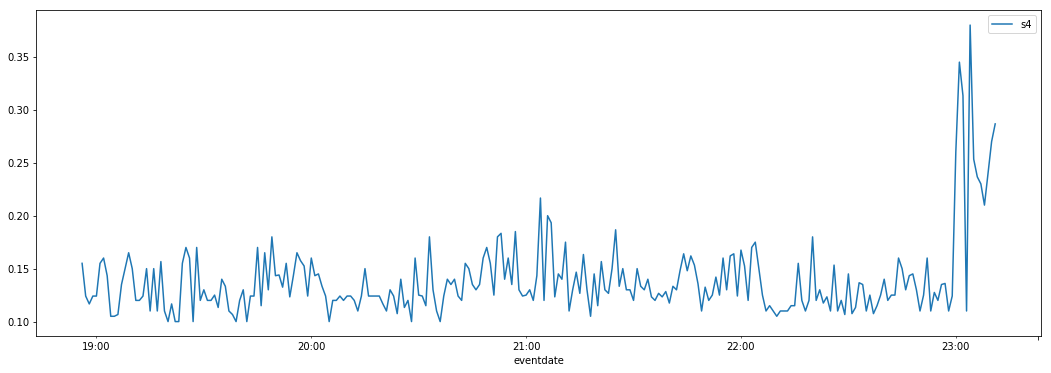

In [4]:
df_s4 = df_s4.resample('1T').mean()
df_s4 = df_s4.interpolate(method='spline', order=3)
df_s4[0:256].plot(figsize=(18, 6));

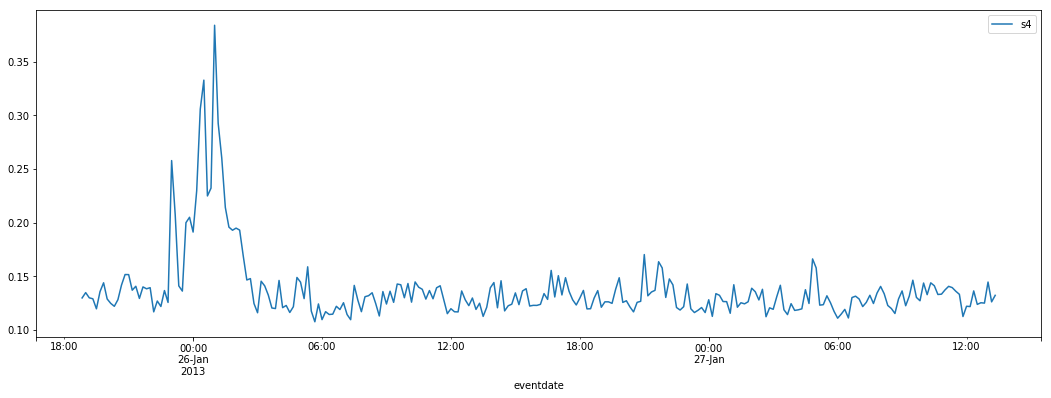

In [5]:
df_s4 = df_s4.resample('10T').mean()
df_s4[0:256].plot(figsize=(18, 6));

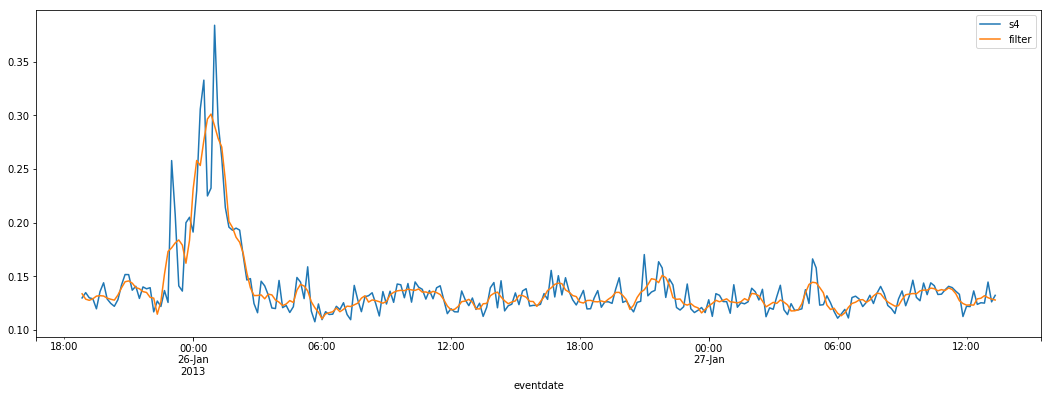

In [6]:
df_s4_avaliate_filter = df_s4.copy()
df_s4_avaliate_filter['filter'] = savgol_filter(df_s4_avaliate_filter.values.ravel(), window, 3)
ax = df_s4_avaliate_filter[0:256].plot(figsize=(18, 6));


In [7]:
original = df_s4
center = df_s4.rolling(window, win_type='gaussian', center=True).mean(std=1.0)
trailing = df_s4.rolling(window, win_type='gaussian').mean(std=1.0)
df_s4 = pd.concat([original, center, trailing], axis=1)
df_s4.columns = ['original', 'center', 'trailing']

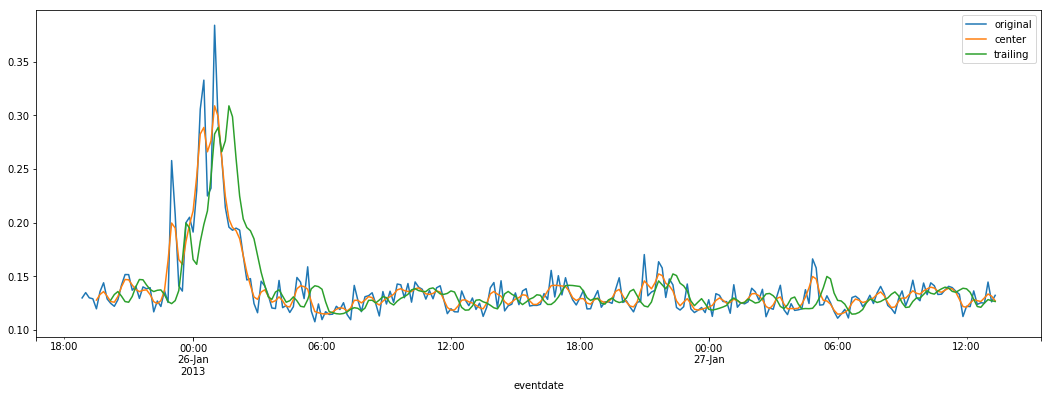

In [8]:
ax = df_s4[0:256].plot(figsize=(18, 6));
#df_s4['trailing'].shift(-7)[0:256].plot(figsize=(18, 6), ax=ax)

